In [1]:
import os
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cmocean
import gsw
from seabird.cnv import fCNV

from cast_to_xarray import *

# Cartopy for producing maps
import cartopy.crs as ccrs                   # import projections
import cartopy.feature as cf                 # import features

import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.geoaxes import GeoAxes
import matplotlib.ticker as mticker

# Get all casts as xarray using function

In [20]:
data_dir = 'data_cruise2'

cast6xr = cast_to_xarray(data_dir+'/station6_loop_filter_teos10_bin.cnv', 6)
cast7xr = cast_to_xarray(data_dir+'/station7_loop_filter_teos10_bin.cnv', 7)
cast8xr = cast_to_xarray(data_dir+'/station8_loop_filter_teos10_bin.cnv', 8)
cast9xr = cast_to_xarray(data_dir+'/slope_loop_filter_teos10_bin.cnv', 9)

castFISxr = cast_to_xarray(data_dir+'/FIS_loop_filter_teos10_bin.cnv', 'Fishers_Island')
castLGxr = cast_to_xarray(data_dir+'/littlegull_loop_filter_teos10_bin.cnv', 'Little_Gull')
castRACExr = cast_to_xarray(data_dir+'/race_loop_filter_teos10_bin.cnv', 'Race')
castWFLTxr = cast_to_xarray(data_dir+'/WFLite_loop_filter_teos10_bin.cnv', 'WF_Lite')
castWFxr = cast_to_xarray(data_dir+'/WF_loop_filter_teos10_bin.cnv', 'WF')




# Combine casts

In [22]:
# which casts to include
castlist = [cast6xr, cast7xr,cast8xr,cast9xr]
#            castFISxr,castLGxr,castRACExr,castWFLTxr,castWFxr

# combine all the casts into one xarray dataset
ctdsection = xr.concat(castlist,"cast")
ctdsection

<xarray.Dataset>
Dimensions:       (cast: 9, depth: 251)
Coordinates:
  * depth         (depth) float64 1.5 2.0 2.5 3.0 ... 125.0 125.5 126.0 126.5
    latitude      (cast) float64 40.78 40.6 40.45 40.2 ... 41.24 41.05 41.05
    longitude     (cast) float64 -71.0 -71.0 -71.01 ... -72.05 -71.47 -71.47
    station       (cast) object 6 7 8 9 ... 'Little_Gull' 'Race' 'WF_Lite' 'WF'
Dimensions without coordinates: cast
Data variables:
    temperature   (cast, depth) float64 nan 16.98 16.98 16.98 ... nan nan nan
    salinity      (cast, depth) float64 nan 32.74 32.74 32.74 ... nan nan nan
    fluorescence  (cast, depth) float64 nan 1.29 1.283 1.309 ... nan nan nan nan

In [23]:
# calculate distance
d = gsw.distance(ctdsection.longitude.values,ctdsection.latitude.values)/1e3 # km
dist = np.cumsum(np.hstack([0,d]))

# add distance coordinate
ctdsection = ctdsection.assign_coords({'distance' : xr.DataArray(dist, coords=[ctdsection.station], dims='cast')})

ctdsection.distance.attrs['units'] = 'km'
#ctdsection

<xarray.Dataset>
Dimensions:       (cast: 9, depth: 251)
Coordinates:
  * depth         (depth) float64 1.5 2.0 2.5 3.0 ... 125.0 125.5 126.0 126.5
    latitude      (cast) float64 40.78 40.6 40.45 40.2 ... 41.24 41.05 41.05
    longitude     (cast) float64 -71.0 -71.0 -71.01 ... -72.05 -71.47 -71.47
    station       (cast) object 6 7 8 9 ... 'Little_Gull' 'Race' 'WF_Lite' 'WF'
  * cast          (cast) object 6 7 8 9 ... 'Little_Gull' 'Race' 'WF_Lite' 'WF'
    distance      (cast) float64 0.0 20.03 36.2 64.45 ... 228.7 282.1 282.3
Data variables:
    temperature   (cast, depth) float64 nan 16.98 16.98 16.98 ... nan nan nan
    salinity      (cast, depth) float64 nan 32.74 32.74 32.74 ... nan nan nan
    fluorescence  (cast, depth) float64 nan 1.29 1.283 1.309 ... nan nan nan nan

In [24]:
# add units for others
ctdsection.depth.attrs['units'] = 'm'
ctdsection.temperature.attrs['units'] = 'degree C'
ctdsection.salinity.attrs['units'] = 'psu'
ctdsection.fluorescence.attrs['units'] = 'mg/m^3'

# Map to understand plot

Text(-73.7, 41.74, 'CTD stations')

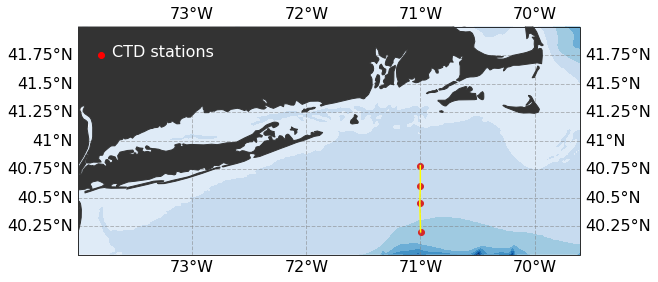

In [129]:
extent = [-74,-69.6,40,42]

# Download ETOPO1 topography for the domain(this may take a minute)
url = 'http://geoport.whoi.edu/thredds/dodsC/bathy/etopo1_bed_g2'
bat = xr.open_dataset(url)
bat = bat.sel(lon=slice(extent[0],extent[1]),lat=slice(extent[2],extent[3]))

projection = ccrs.PlateCarree()

fig, ax = plt.subplots(figsize=(9, 13),
                           subplot_kw=dict(projection=projection))
ax.set_extent(extent)

# Plot topography
bat['topo'].plot.contourf(
        ax=ax,levels=np.linspace(-500,100,10),add_colorbar=False,extend='neither',cmap='Blues_r',transform=projection)

_ = ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                                edgecolor='face', facecolor='0.2'),
                                                zorder=3)

# plot ADCP track
plt.plot(ctdsection.longitude, ctdsection.latitude, color='yellow')

# plot CTD stations
ctdsection.plot.scatter('longitude', 'latitude', color='tab:red')#,transform=projection)

gl = ax.gridlines(draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')

plt.plot(-73.8, 41.75,'ro',transform=projection,zorder=5)
plt.text(-73.7,41.74,'CTD stations',color='w',transform=projection,zorder=5)

# Plot cross sections!

Text(0.5, 1.0, 'Temperature Section')

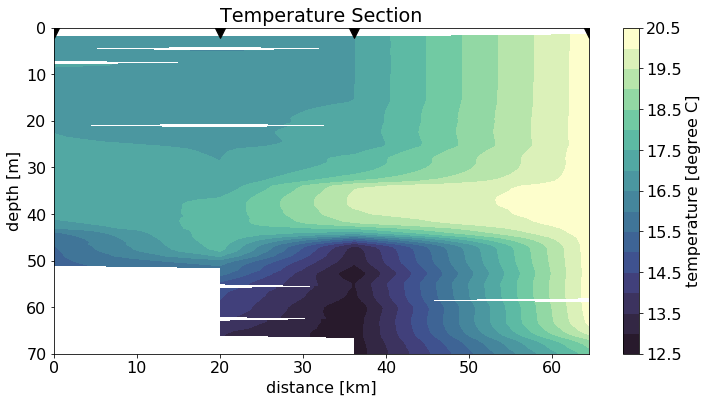

In [16]:
def beautifications(ax):
    ax.plot(ctdsection.distance,ctdsection.distance.size*[0],
             'kv',markersize=20)
    ax.set_ylim(70,0)
#    ax.set_xlim(-.5,65)
    
fig = plt.figure(figsize=(12,6))
plt.rcParams.update({'font.size': 16})

ax = fig.add_subplot(111)
ctdsection.temperature.plot.contourf('distance','depth',levels=20,cmap=cmocean.cm.deep_r)
beautifications(ax)

plt.title("Temperature Section")

#plt.savefig('Figures/temperaturesection789.png')

Text(0.5, 1.0, 'Salinity Section')

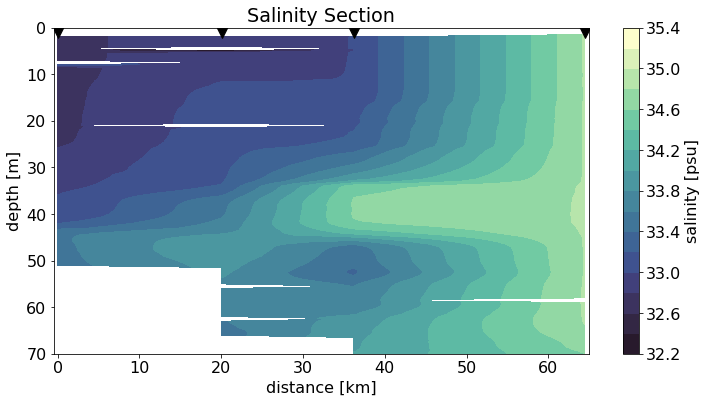

In [17]:
def beautifications(ax):
    ax.plot(ctdsection.distance,ctdsection.distance.size*[0],
             'kv',markersize=20)
    ax.set_ylim(70,0)
    ax.set_xlim(-.5,65)
    
fig = plt.figure(figsize=(12,6))
plt.rcParams.update({'font.size': 16})

ax = fig.add_subplot(111)
ctdsection.salinity.plot.contourf('distance','depth',levels=20,cmap=cmocean.cm.deep_r)
beautifications(ax)

plt.title("Salinity Section")

# plt.savefig('Figures/salinitysection789.png')

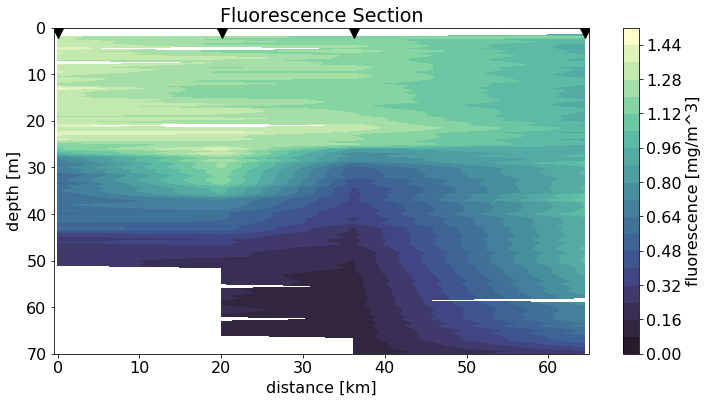

In [19]:
def beautifications(ax):
    ax.plot(ctdsection.distance,ctdsection.distance.size*[0],
             'kv',markersize=20)
    ax.set_ylim(70,0)
    ax.set_xlim(-.5,65)
    
fig = plt.figure(figsize=(12,6))
plt.rcParams.update({'font.size': 16})

ax = fig.add_subplot(111)
ctdsection.fluorescence.plot.contourf('distance','depth',levels=20,cmap=cmocean.cm.deep_r)
beautifications(ax)

plt.title("Fluorescence Section")

plt.savefig('Figures/Cruise2_fluorescence_section6789.png')

# Using all casts

Text(0.5, 1.0, 'Fluorescence Section')

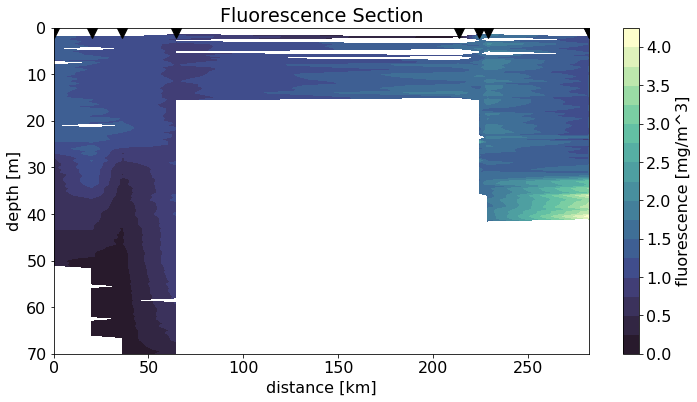

In [26]:
def beautifications(ax):
    ax.plot(ctdsection.distance,ctdsection.distance.size*[0],
             'kv',markersize=20)
    ax.set_ylim(70,0)
#     ax.set_xlim(-.5,100)
    
fig = plt.figure(figsize=(12,6))
plt.rcParams.update({'font.size': 16})

ax = fig.add_subplot(111)
ctdsection.fluorescence.plot.contourf('distance','depth',levels=20,cmap=cmocean.cm.deep_r)
beautifications(ax)

plt.title("Fluorescence Section")

# plt.savefig('Figures/Cruise2_fluorescence_allstns.png')